## Autoencoders

An autoencoder is simply a neural network that learns to reconstruct its own inputs. Typically, it learns a mapping to a low-dimensional space, then it learns to take that mapping and reproduce the original data. The simplest example of an autoencoder is Principal Component Analysis; the principal components represent orthogonal manifolds in the data, where the first principal component has the highest variance, the second has the second most variance, and so on. Taking the top-N principal components is a way of doing "dimensionality reduction" on the data. Conceptually, this process captures common features of the dataset. Neural network autoencoders do much the same thing. The diagram below shows the structure of an autoencoder.

![Autoencoder diagram from Wikipedia](resources/autoencoder_structure_wikipedia.png)

The **latent vector** $Z$ in the autoencoder represents the low-dimensional representation of the data $X$.

## Variational Autoencoders

Variational autoencoders and an interesting extension to regular autoencoders. Suppose the latent vector $Z$ is a normally-distributed random variable. After training, the entire vector space of $Z$ will (hopefully) correspond to viable reconstructions of real data. In other words, we could feed our own vector into the decoder neural network, and get a reconstruction back out.

To do this, we just need to make sure the latent vector is normally distributed. We apply a penalty to minimize the KL divergence between $Z$ and a normal distribution. KL divergence is simply a measure of how different two distributions are:

$$D_{KL} (P \Vert Q) = \int_{-\infty}^{\infty} p(x) \log \frac{p(x)}{q(x)} dx$$

Given a latent vector with mean $\mu$ and variance $\sigma^2$, we apply the penalty

$$C_{KL} = -\frac{1 + \sigma - \mu^2 - e^{\sigma}}{2}$$

to push the latent vector towards a normal distribution.

## Building the model

Let's build a very simple autoencoder model using Keras and train it on some sample data. Our autoencoder will be slightly different from a conventional autoencoder, because we also want the encoder and decoder to have access to information about whether or not the calcium fluorescence trace that we are feeding it corresponds to an illicited spike.

The first thing we need to do is add a new layer to represent the variational part. To do this, we'll reference the variational autoencoder example in the Keras examples directory [here](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py). We'll also add some extra layers that we can use later.

In [1]:
# First, let's load all the dependencies we will need.
# The utils module contains all the functions for loading
# and processing data; this tutorial will focus on building
# the deep learning models.

from __future__ import division
from __future__ import print_function

import os
import sys

from imp import reload
import utils; reload(utils)

from sklearn.decomposition import PCA
import keras
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

# Checks that you've got Keras 2.0.0 installed (for compatibility).
assert keras.__version__ == '2.0.2', 'Invalid Keras version.'

Using TensorFlow backend.


In [2]:
class VariationalLayer(keras.layers.Layer):
    """A Dense layer that outputs a normally distributed vector."""
    
    def __init__(self, output_dim, epsilon_std=1., **kwargs):
        self.output_dim = output_dim
        self.epsilon_std = epsilon_std
        super(VariationalLayer, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.z_mean_kernel = self.add_weight(
            shape=(input_shape[1], self.output_dim),
            initializer='glorot_normal',
            trainable=True)
        self.z_mean_bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zero',
            trainable=True)
        self.z_log_var_kernel = self.add_weight(
            shape=(input_shape[1], self.output_dim),
            initializer='glorot_normal',
            trainable=True)
        self.z_log_var_bias = self.add_weight(
            shape=(self.output_dim,),
            initializer='zero',
            trainable=True)
        
        super(VariationalLayer, self).build(input_shape)
    
    def call(self, x):
        z_mean = K.dot(x, self.z_mean_kernel) + self.z_mean_bias
        z_log_var = K.dot(x, self.z_log_var_kernel) + self.z_log_var_bias
        epsilon = K.random_normal(shape=K.shape(z_log_var),
                                  mean=0.,
                                  stddev=self.epsilon_std)
        
        # Computes variational loss.
        kl_inside = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        self.kl_loss = -0.5 * K.sum(kl_inside, axis=-1)

        # Samples from the distribution to get the output tensor.
        return z_mean + K.exp(z_log_var / 2) * epsilon
    
    def loss(self, variational_weight=1.):
        """A loss function that can be used by a Keras model."""
        
        loss = keras.losses.mean_squared_error
        
        def variational_loss(x, x_rec):
            return loss(x, x_rec) + self.kl_loss * variational_weight
        
        return variational_loss
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)
    
    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'epsilon_std': self.epsilon_std,
            'loss': self
        }
        base_config = super(VariationalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

This layer calculates the KL divergence loss for us, and provides a loss function that combines it with mean squared reconstruction error. Let's train this on some toy data to visualize what it is doing.

In [3]:
NUM_LATENT_DIMS = 2
variational = VariationalLayer(NUM_LATENT_DIMS)

# Builds the encoder model.
input_var = keras.layers.Input(shape=(10,))
x = keras.layers.Dense(20, activation='tanh')(input_var)
x = variational(x)
encoder = keras.models.Model(input_var, x)

# Builds the decoder model.
input_var = keras.layers.Input(shape=(NUM_LATENT_DIMS,))
x = keras.layers.Dense(20, activation='tanh')(input_var)
x = keras.layers.Dense(20, activation='tanh')(x)
x = keras.layers.Dense(10)(x)
decoder = keras.models.Model(input_var, x)

# Builds the trainable model.
input_var = keras.layers.Input(shape=(10,))
trainable_model = keras.models.Model(inputs=input_var,
                                     outputs=decoder(encoder(input_var)))
trainable_model.compile(loss=variational.loss(1e-2),
                        optimizer='adam',
                        metrics=['accuracy'])

# The toy data will be random one-hot encoded values.
idxs = np.random.randint(0, 10, size=(10000))
toy_distribution = np.eye(10)[idxs]

# To train the autoencoder, train distribution -> distribution.
trainable_model.fit(toy_distribution, toy_distribution,
                    epochs=10, verbose=2, batch_size=32)

print('Done training the model.')

Epoch 1/10
1s - loss: 0.0960 - acc: 0.1501
Epoch 2/10
1s - loss: 0.0884 - acc: 0.2238
Epoch 3/10
1s - loss: 0.0857 - acc: 0.3423
Epoch 4/10
1s - loss: 0.0811 - acc: 0.5197
Epoch 5/10
1s - loss: 0.0715 - acc: 0.7303
Epoch 6/10
1s - loss: 0.0619 - acc: 0.8571
Epoch 7/10
1s - loss: 0.0532 - acc: 0.9316
Epoch 8/10
1s - loss: 0.0489 - acc: 0.9642
Epoch 9/10
1s - loss: 0.0465 - acc: 0.9826
Epoch 10/10
1s - loss: 0.0445 - acc: 0.9869
Done training the model.


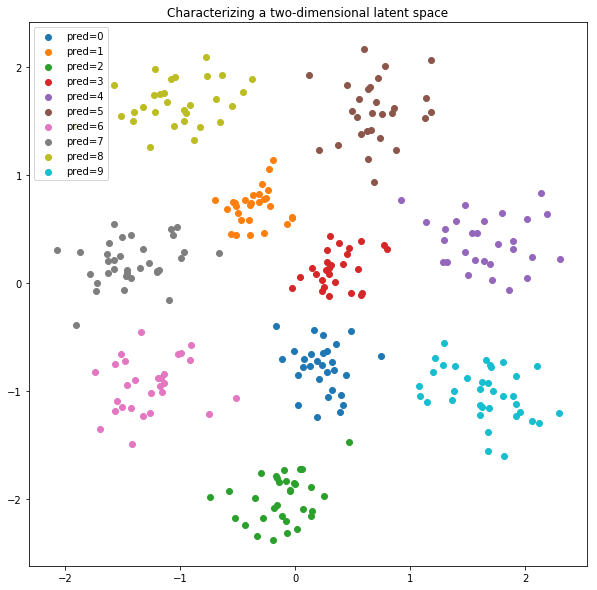

In [4]:
# Uses the decoder to sample from the data distribution.
idxs = np.random.randint(0, 10, size=(300))
inputs = np.eye(10)[idxs]
preds = encoder.predict(inputs)

# Maps the latent space to the predict outputs.
plt.figure(figsize=(10, 10))
for i in range(10):
    ith_preds = preds[idxs == i]
    plt.scatter(ith_preds[:, 0], ith_preds[:, 1], label='pred=%d' % i)
plt.legend(loc=2)
plt.title('Characterizing a two-dimensional latent space')
plt.show()

As we hoped, the latent dimension clusters the data according to what we want to reconstruct.

Now that we've got a variational layer, we can build our model. This model will be a bit more complicated than the one from above, but fundamentally basically the same. We want to feed it the additional spike / no-spike information, so we'll give that information to the encoder and the decoder.

In [5]:
def check_built(f):
    """A simple wrapper that checks if the model is built, and if not builds it."""
    
    def wrapper(self, *args, **kwargs):
        if not hasattr(self, '_built') or not self._built:
            self.build()
            self._built = True
        return f(self, *args, **kwargs)
    return wrapper


def check_calcium_spikes(f):
    """A simple wrapper that checks the calcium and spike inputs."""
    
    def wrapper(self, calcium, *args, **kwargs):
        assert np.ndim(calcium) == 2
        
        # Checks that the calcium data is correct.
        if calcium.shape[1] != self.num_input:
            raise ValueError('This autoencoder expects data with '
                             '%d time bins; got %d time bins.'
                             % (self.num_input, calcium.shape[1]))
        return f(self, calcium, *args, **kwargs)
    return wrapper


class VariationalAutoencoder(object):
    """A Variational Autoencoder to approximate the spikefinder data."""
    
    def __init__(self, num_input, num_latent=256):
        """Initializes the autoencoder parameters.
        
        Args:
            num_input: int, the number of dimensions in the dataset
                you are trying to approximate.
            num_latent: int, the number of latent dimensions to
                map the data to.
        """
        
        self._num_input = num_input
        self._num_latent = num_latent
        
        # Initializes placeholders for the encoder and decoder models.
        self._encoder, self._decoder, self._encoder_decoder = None, None, None
    
    @property
    def num_input(self):
        return self._num_input
    
    @property
    def num_latent(self):
        return self._num_latent
    
    def build(self, encoder_dims=[128, 128], decoder_dims=[128, 128]):
        """Builds the encoder and decoder models."""
        
        input_calcium = keras.layers.Input(shape=(self.num_input,), name='input_calcium')
        latent_vec = keras.layers.Input(shape=(self.num_latent,), name='latent_vec')
        variational_layer = VariationalLayer(self.num_latent)
        
        # Builds the encoder.
        calcium_rep = keras.layers.Reshape((self.num_input, 1))(input_calcium)
        calcium_delta = utils.DeltaFeature()(calcium_rep)
        calcium_quad = utils.QuadFeature()(calcium_rep)
        calcium_delta_quad = utils.QuadFeature()(calcium_delta)
        x = keras.layers.Concatenate()([calcium_rep, calcium_delta, calcium_quad])
        x = keras.layers.LSTM(64, return_sequences=False)(x)
        variational_output = variational_layer(x)
        self._encoder = keras.models.Model(inputs=[input_calcium],
                                           outputs=variational_output)
        
        # Builds the decoder.
        x = latent_vec
        x = keras.layers.RepeatVector(self.num_input)(x)
        x = keras.layers.LSTM(64, return_sequences=True)(x)
        x = keras.layers.Dense(1)(x)
        calcium_pred = keras.layers.Reshape((self.num_input,))(x)
        self._decoder = keras.models.Model(inputs=[latent_vec],
                                           outputs=[calcium_pred])
        
        output_calcium = self._decoder([variational_output])
        self._encoder_decoder = keras.models.Model(inputs=[input_calcium],
                                                   outputs=[output_calcium])
        self._encoder_decoder.compile(loss=variational_layer.loss(1e-4),
                                      optimizer='adam',
                                      metrics={'did_spike': 'accuracy'})
    
    @check_built
    @check_calcium_spikes
    def encode(self, calcium):
        """Encodes a sample to get the latent vector associated with it.
        
        Args:
            calcium: 2D Numpy array with shape (sample_dim, num_time_bins), the
                calcium fluorescence data.
        """
        
        return self._encoder.predict([calcium])
    
    @check_built
    def sample(self, num_samples=None, latent_vec=None):
        """Produces samples from the model by feeding the decoder a random vector.
        
        Args:
            num_samples: int (default: None), number of samples to produce
                from the model, if .
            latent_vec: a 2D Numpy array to use instead of generating a new one.
        
        Returns:
            calcium_pred: 2D Numpy array with shape (num_samples, num_inputs),
                the predicted calcium trace.
        """
        
        if latent_vec is None:
            assert num_samples is not None, 'Must specifiy `num_samples`.'
            latent_vec = np.random.normal(loc=0., scale=1.,
                                          size=(num_samples, self.num_latent))
        else:
            num_samples = latent_vec.shape[0]
        
        calcium_pred = self._decoder.predict([latent_vec])
        return calcium_pred
    
    @check_built
    @check_calcium_spikes
    def predict(self, calcium):
        """Gets model predictions on some input data.
        
        Args:
            calcium: 2D Numpy array with shape (sample_dim, num_time_bins), the
                calcium fluorescence data.
        """
        
        return self._encoder_decoder.predict([calcium])

    @check_built
    @check_calcium_spikes
    def train(self, calcium, epochs=10):
        """Trains the model on some input data.
        
        Args:
            calcium: 2D Numpy array with shape (sample_dim, num_time_bins), the
                calcium fluorescence data.
            epochs: int, number of training epochs.
        """
        
        # Trains the encoder-decoder on the data.
        self._encoder_decoder.fit([calcium], [calcium],
                                  epochs=epochs, batch_size=32, verbose=2)

Instead of training on all the data to start off with, let's look at a subset of the data. We'll also normalize each sample over time, then unnormalize them to get back the original traces; this helps the stability of the neural network learning process.

In [6]:
NUM_VAR_TRAIN = 1000

calcium, did_spike = utils.load_dataset()
num_dimensions = calcium.shape[1]

def get_evenly_split_dataset(num_samples):
    """Gets an evenly-split sample of the data."""
    
    calcium, did_spike = utils.load_dataset()

    spike_idxs = np.arange(calcium.shape[0])[did_spike == 1]
    nospike_idxs = np.arange(calcium.shape[0])[did_spike == 0]
    spike_idxs = np.random.choice(spike_idxs, num_samples // 2)
    nospike_idxs = np.random.choice(nospike_idxs, num_samples // 2)
    idxs = np.concatenate([spike_idxs, nospike_idxs])

    return calcium[idxs], did_spike[idxs]

# Gets a subset of the data..
calcium, did_spike = get_evenly_split_dataset(NUM_VAR_TRAIN)

model = VariationalAutoencoder(num_dimensions)
model.train(calcium, epochs=100)

Epoch 1/100
2s - loss: 1.1462
Epoch 2/100
1s - loss: 1.0583
Epoch 3/100
1s - loss: 1.0280
Epoch 4/100
1s - loss: 0.9969
Epoch 5/100
1s - loss: 0.9055
Epoch 6/100
1s - loss: 0.8031
Epoch 7/100
1s - loss: 0.7418
Epoch 8/100
1s - loss: 0.7098
Epoch 9/100
1s - loss: 0.6524
Epoch 10/100
1s - loss: 0.6163
Epoch 11/100
1s - loss: 0.5779
Epoch 12/100
1s - loss: 0.5527
Epoch 13/100
1s - loss: 0.5339
Epoch 14/100
1s - loss: 0.5250
Epoch 15/100
1s - loss: 0.5128
Epoch 16/100
1s - loss: 0.5084
Epoch 17/100
1s - loss: 0.4963
Epoch 18/100
1s - loss: 0.4865
Epoch 19/100
1s - loss: 0.4907
Epoch 20/100
1s - loss: 0.4963
Epoch 21/100
1s - loss: 0.4908
Epoch 22/100
1s - loss: 0.4746
Epoch 23/100
1s - loss: 0.4654
Epoch 24/100
1s - loss: 0.4606
Epoch 25/100
1s - loss: 0.4525
Epoch 26/100
1s - loss: 0.4428
Epoch 27/100
1s - loss: 0.4410
Epoch 28/100
1s - loss: 0.4471
Epoch 29/100
1s - loss: 0.4461
Epoch 30/100
1s - loss: 0.4386
Epoch 31/100
1s - loss: 0.4357
Epoch 32/100
1s - loss: 0.4177
Epoch 33/100
1s -

Now that we've got a trained model, we can visualize what it thinks the calcium traces look like a) when there is a spike and b) when there isn't a spike. First, let's look at how well the model reconstructs the inputs it's given.

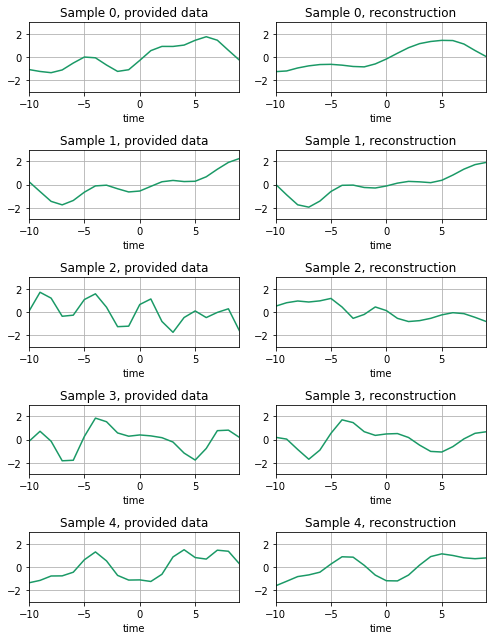

In [7]:
calcium, did_spike = calcium[:5], did_spike[:5]
pred_calcium = model.predict(calcium)

# Plot the data where no spike was observed on the left,
# and the data where a spike was observed on the right.
fig = plt.figure(figsize=(7, 9))
d = calcium.shape[1] / 2
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    utils.plot_sample(calcium=calcium[i],
                      t_start=-d,
                      t_end=d - 1,
                      sampling_rate=1)
    plt.title('Sample %d, provided data' % i)
    plt.subplot(5, 2, 2 * i + 2);
    utils.plot_sample(calcium=pred_calcium[i],
                      t_start=-d,
                      t_end=d - 1,
                      sampling_rate=1)
    plt.title('Sample %d, reconstruction' % i)

plt.tight_layout()
plt.show()

Next, let's do PCA on the encoded vectors corresponding to a bunch of data.

Explained variance:
    Principal component 0: 0.299
    Principal component 1: 0.119
    Principal component 2: 0.089
    Principal component 3: 0.059
    Principal component 4: 0.040
    Principal component 5: 0.031
    Principal component 6: 0.031
    Principal component 7: 0.018
    Principal component 8: 0.012
    Principal component 9: 0.010


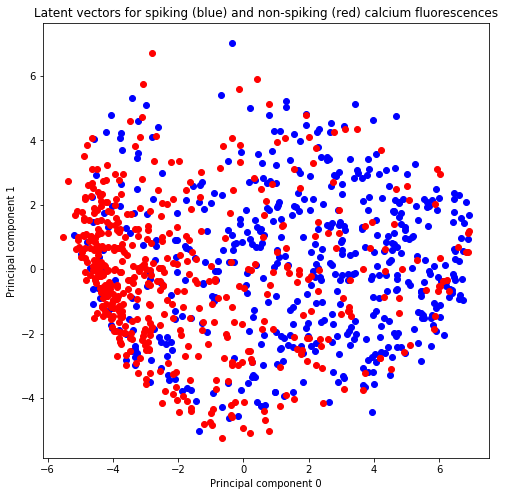

In [8]:
# Encodes some samples in latent vector space.
NUM_PCA = 1000
calcium, did_spike = get_evenly_split_dataset(NUM_PCA)

# Encodes data into (NUM_PCA, num_latent)-dimensional array.
latent_vecs = model.encode(calcium)

# Performs PCA on the latent vectors.
pca = PCA(n_components=10, copy=False)
pca.fit(latent_vecs)

# Prints explained variance.
print('Explained variance:')
for i, var in enumerate(pca.explained_variance_ratio_):
    print('    Principal component %d: %.3f' % (i, var))

# Plots embedded latent vectors in 2D space.
pca_vecs = pca.transform(latent_vecs)
x0, x1 = pca_vecs[:, 0], pca_vecs[:, 1]
plt.figure(figsize=(8, 8))
plt.plot(x0[did_spike == 0], x1[did_spike == 0], 'ob')
plt.plot(x0[did_spike == 1], x1[did_spike == 1], 'or')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 1')
plt.title('Latent vectors for spiking (blue) and non-spiking (red) calcium fluorescences')
plt.show()

Because the data is mostly split along the first principle component, that means that spiking (according to our variational autoencoder model) causes more variance than other noisy artifacts. This is a pretty weak conclusion (we expected as much, because calcium imaging is supposed to correlate with spiking), but it is still a good sanity check that this shows up in our model.

Next, let's see which patterns the model is learning to represent the data distribution. By manually inspecting the points, we can see that the model mainly cares about if the calcium fluorescence increases or decreases.

<IPython.core.display.Javascript object>


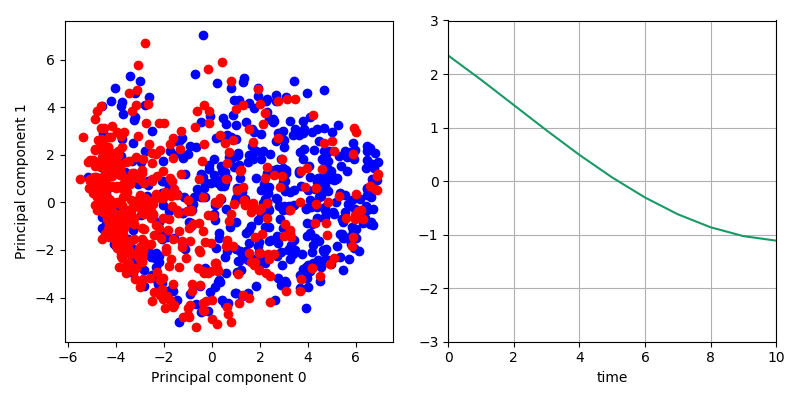

7

In [9]:
%matplotlib notebook

from ipywidgets import interactive
from IPython.display import display
from scipy.spatial import KDTree

# For finding the nearest neighbor.
tree = KDTree(list(zip(x0.ravel(), x1.ravel())))

_, idx = tree.query((0, 6))

# Creates the plot from above, so we can annotate it.
fig = plt.figure(figsize=(8, 4))
pca_ax = fig.add_subplot(1, 2, 1)

plt.plot(x0[did_spike == 0], x1[did_spike == 0], 'ob')
plt.plot(x0[did_spike == 1], x1[did_spike == 1], 'or')
plt.xlabel('Principal component 0')
plt.ylabel('Principal component 1')

def base_plot(idx_old, idx_new):
    color = 'b' if did_spike[idx_old] == 0 else 'r'
    pca_ax.plot(x0[idx_old:idx_old+1], x1[idx_old:idx_old+1], 'o' + color)
    pca_ax.plot(x0[idx_new:idx_new+1], x1[idx_new:idx_new+1], 'og')

idx_old = 0
    
calcium_ax = fig.add_subplot(1, 2, 2)
utils.plot_sample(calcium=calcium[0], t_start=0, t_end=10, sampling_rate=1)

def onclick(event):
    global idx_old
    
    # Gets the nearest neighbor point.
    x, y = event.xdata, event.ydata
    _, idx_new = tree.query((x, y))
        
    # Clears the left plot.
    base_plot(idx_old, idx_new)
    idx_old = idx_new
    
    # Plots the calcium trace.
    plt.sca(calcium_ax)
    plt.cla()
    utils.plot_sample(calcium=calcium[idx_new],
                      t_start=-10,
                      t_end=9,
                      sampling_rate=1)
    plt.show()
    
w = fig.canvas.mpl_connect('button_press_event', onclick)

plt.tight_layout()
plt.show()
display(w)